# Evaluate Primary Site and Tumor Normal Classifier

In [27]:
import os
import json
import requests
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

# Load Trained Model and Test Data

In [29]:
# Setup S3 connection to download the training set and trained model
import boto3
from botocore.handlers import disable_signing

bucket_name = "stuartlab"
endpoint = "s3.nautilus.optiputer.net"

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
os.environ["S3_ENDPOINT"] = endpoint

# Create anonymous access to the bucket so this works locally and in colab
session = boto3.session.Session()
resource = boto3.resource("s3", endpoint_url="https://{}".format(endpoint))
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
bucket = resource.Bucket(bucket_name)

# Output the data and checksums for the dataset and trained model
print("Dataset and Model:")
for obj in bucket.objects.filter(Prefix="pancan-gtex"):
    print(obj.last_modified.isoformat(), obj.e_tag[1:-1], obj.key) 

Dataset and Model:
2018-11-23T17:26:45.350000+00:00 ef1c9c15b5a1fd836521f0759e57dfa7-120 pancan-gtex
2019-01-25T04:23:03.187000+00:00 20a89dbc58cfb88efaad1567b8f62cff pancan-gtex/ensemble-to-hugo.tsv
2019-01-25T04:22:59.779000+00:00 2507895ba8b46cb1458b40764b81ee14-47 pancan-gtex/pancan-gtex-pruned.h5
2019-01-25T04:25:29.799000+00:00 10d6cce19b63beb8809d4eca687df355 pancan-gtex/pruned-model.h5
2019-01-25T04:25:28.344000+00:00 7850096c28a10a7740180045581bdce0 pancan-gtex/pruned-params.json


In [30]:
# Load params and trained model from S3
r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/pruned-params.json")
params = r.json()

r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/pancan-gtex/pruned-model.h5")

import tempfile
temp_path = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
open(temp_path, "wb").write(r.content)

model = tf.keras.models.load_model(temp_path)
os.remove(temp_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5540)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5540)              22160     
_________________________________________________________________
dense (Dense)                (None, 64)                354624    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 34)                2210      
Total para

In [32]:
if not os.path.exists("pancan-gtex-pruned.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex-pruned.h5", "pancan-gtex-pruned.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex-pruned.h5", "samples")
Y = pd.read_hdf("pancan-gtex-pruned.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loading dataset...
Loaded 17277 samples with 5540 features and 40 labels


In [33]:
# Convert tumor normal and primary site to numeric values so we can plot confusion and errors againsts them
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index)

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

In [34]:
Y._primary_site.value_counts()

Brain                   1846
Lung                    1410
Breast                  1391
Kidney                  1043
Skin                    1026
Esophagus                848
Prostate                 648
Colon                    639
Stomach                  624
Blood Vessel             606
Thyroid Gland            571
Head and Neck region     564
Liver                    531
Adipose Tissue           515
Ovary                    515
Bladder                  435
Muscle                   396
Heart                    377
Pancreas                 350
Blood                    337
Testis                   319
Cervix                   309
Thyroid                  279
Nerve                    278
Soft tissue,Bone         264
Endometrium              204
Paraganglia              185
White blood cell         173
Uterus                   135
Adrenal Gland            128
Thymus                   121
Pituitary                107
Rectum                   103
Name: _primary_site, dtype: int64

In [35]:
X_train = X.values[params["train_indices"]]
Y_train = Y.iloc[params["train_indices"]]

X_test = X.values[params["test_indices"]]
Y_test = Y.iloc[params["test_indices"]]

In [36]:
# Predict all test samples
predictions = model.predict(X_test)

## Evaluate

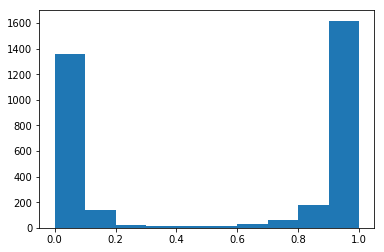

Tumor/Normal Confusion Matrix
[[1527   42]
 [  25 1862]]


In [37]:
# Plot the distribution of tumor/normal values and confusion matrix
plt.hist(predictions[:,0])
plt.show()

from sklearn.metrics import confusion_matrix
print("Tumor/Normal Confusion Matrix")
print(confusion_matrix(Y_test["tumor_normal_value"], np.round(predictions[:,0])))

In [38]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix optionally normalized by class size
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

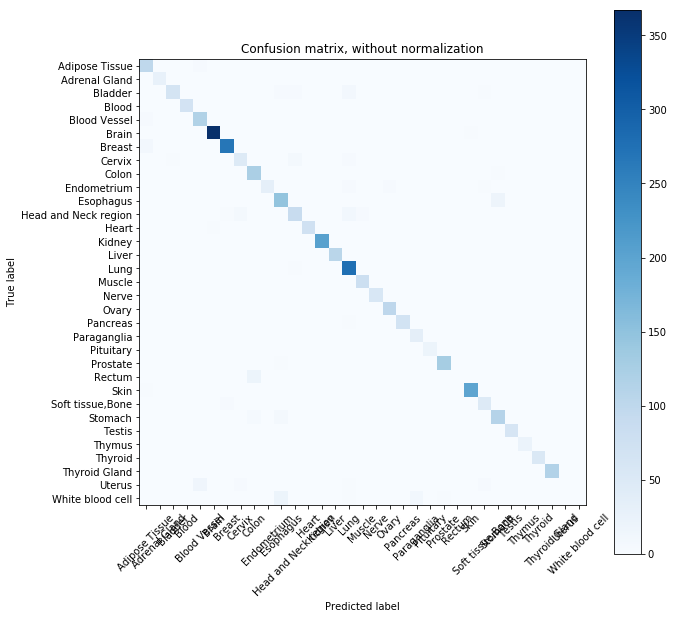

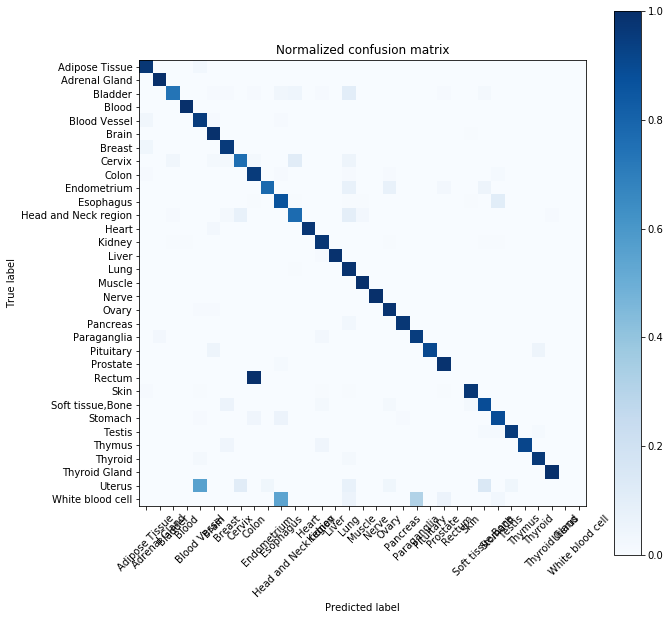

In [39]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    Y_test["primary_site_value"], np.array([np.argmax(p[1:-1]) for p in predictions]))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()